## In this notebook the model for news sentiments analysis is test and the average error obtained for the model is reported.

In [228]:
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import keras
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
finwiz_url = 'https://finviz.com/quote.ashx?t='

In [229]:
def get_data(ticker):
    df = DataReader(ticker, data_source='yahoo', start='2011-01-01', end=datetime.now())
    plt.plot(df["Close"],label=ticker)
    plt.legend()
    return df

In [230]:
list_tick=['BNS', 'RY', 'TD','BMO','CM','C','JPM','IBN', 'WTBA','BAC','AXP','PNC','GS']

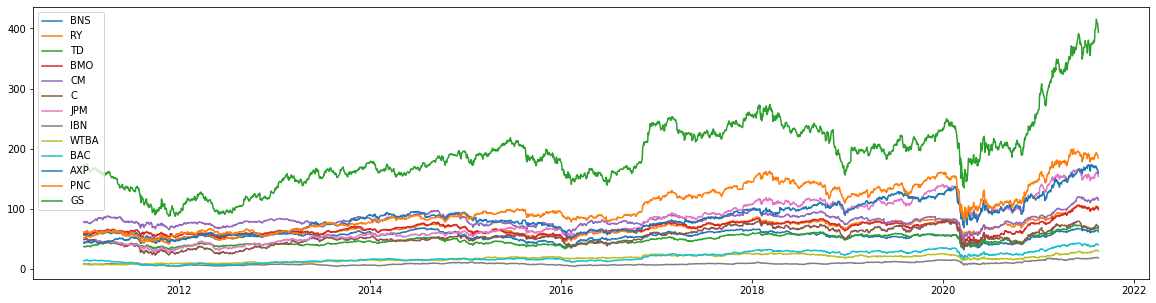

In [231]:
for i in list_tick:
    get_data(i)

## Web Scraping performed using Beautiful Soup to extract the headlines related to the banks.

In [233]:
news_tables = {}
tickers = ['BNS', 'RY', 'TD','BMO','CM','C','JPM','IBN', 'WTBA','BAC','AXP','PNC','GS']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [234]:
bns= news_tables['BNS']
bns_tr = bns.findAll('tr')

for i, table_row in enumerate(bns_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if i == 10:
        break

Scotiabank recognized for Outstanding Leadership in the Global Finance 2021 Sustainable Finance Awards
Aug-19-21 09:41AM  
Scotiabank Issues USD 1 Billion Sustainability Bond
09:01AM  
Bank of Nova Scotia (BNS) Reports Next Week: Wall Street Expects Earnings Growth
Aug-17-21 03:00PM  
Scotiabank to Announce Third Quarter 2021 Results
09:00AM  


## Creating a list of Bank symbol, date, time and corresponding headline

In [253]:
parsed_news = []

for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, text])
        
parsed_news[-10:]

[['GS',
  'Jul-20-21',
  '08:40PM',
  'Google-Backed Startup XtalPi Taps Goldman to Seek Fresh Funds'],
 ['GS',
  'Jul-20-21',
  '02:10PM',
  'Biden Team Sees Chip Supply Gains, Relief Soon for Carmakers'],
 ['GS',
  'Jul-20-21',
  '01:36PM',
  '20 Most Valuable Financial Companies in the World'],
 ['GS',
  'Jul-20-21',
  '12:04PM',
  'Stock market is at risk of a correction if this happens amid the spread of the Delta variant'],
 ['GS',
  'Jul-20-21',
  '03:30AM',
  'SoftBank Backs Food Delivery App Swiggys $1.25 Billion Funding'],
 ['GS',
  'Jul-19-21',
  '03:28PM',
  'Oil Leads Market Plunge as Virus Rattles Faith in Recovery'],
 ['GS',
  'Jul-19-21',
  '10:03AM',
  'Zoom Bets on AI with $14.7 Billion Deal to Acquire Five9'],
 ['GS',
  'Jul-17-21',
  '08:34AM',
  'JPMorgan, Home Depot Lead 5 Dow Jones Stocks Near Buy Points'],
 ['GS',
  'Jul-16-21',
  '08:29AM',
  'Big U.S. Banks Crush Q2 Earnings, Is Loan Growth On The Cards?'],
 ['GS',
  'Jul-16-21',
  '07:32AM',
  'Manchester Cit

## Assigning the sentiment score to all the news headlines using the SentimentIntensityAnalyzer from NLTK vader library

In [238]:
columns = ['ticker', 'date', 'time', 'headline']
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
vader = SentimentIntensityAnalyzer()

scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)

parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,compound,neg,neu,pos
0,BNS,2021-08-19,09:41AM,Scotiabank recognized for Outstanding Leadersh...,0.7906,0.0,0.611,0.389
1,BNS,2021-08-19,09:01AM,Scotiabank Issues USD 1 Billion Sustainability...,0.0000,0.0,1.000,0.000
2,BNS,2021-08-17,03:00PM,Bank of Nova Scotia (BNS) Reports Next Week: W...,0.3818,0.0,0.822,0.178
3,BNS,2021-08-17,09:00AM,Scotiabank to Announce Third Quarter 2021 Results,0.0000,0.0,1.000,0.000
4,BNS,2021-08-05,09:00AM,Scotiabank to Announce Third Quarter 2021 Results,0.0000,0.0,1.000,0.000


In [239]:
parsed_and_scored_news.tail()

,ticker,date,time,headline,compound,neg,neu,pos
1295,GS,2021-07-19,03:28PM,Oil Leads Market Plunge as Virus Rattles Faith...,0.4215,0.000,0.763,0.237
1296,GS,2021-07-19,10:03AM,Zoom Bets on AI with $14.7 Billion Deal to Acq...,0.0000,0.000,1.000,0.000
1297,GS,2021-07-17,08:34AM,"JPMorgan, Home Depot Lead 5 Dow Jones Stocks N...",0.0000,0.000,1.000,0.000
1298,GS,2021-07-16,08:29AM,"Big U.S. Banks Crush Q2 Earnings, Is Loan Grow...",0.2500,0.113,0.704,0.183
1299,GS,2021-07-16,07:32AM,Manchester City-owner raises $650m in mega deb...,-0.3612,0.263,0.737,0.000


In [240]:
main_f=pd.DataFrame()
main_f["Dates"]=n_range=pd.date_range("2018-12-26",datetime.now())
main_f.index=main_f["Dates"]
del main_f["Dates"]                    
                    
for tick in list_tick:
    t_f=pd.DataFrame()
    t_f[tick]=parsed_and_scored_news[parsed_and_scored_news["ticker"]==tick].groupby(['date']).mean()['compound']
    main_f=pd.concat([main_f, t_f], axis=1)

## This is the plot obtained for the mean of the compound sentiment for each back per day. We find that the data is very sparse before March 2021.

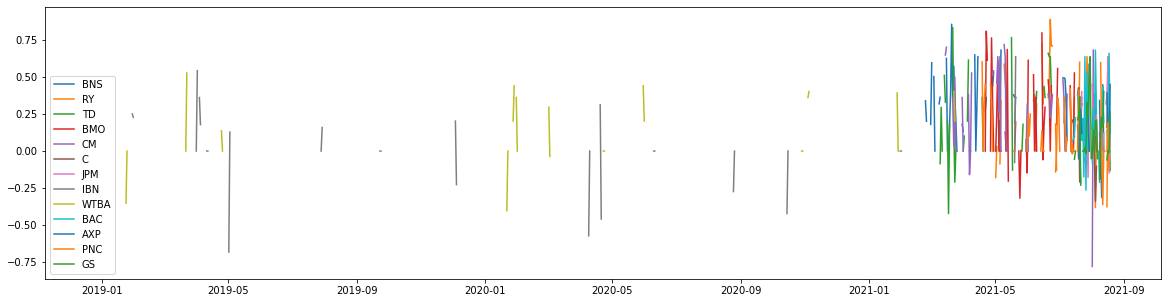

In [241]:
plt.rcParams["figure.figsize"] = (20,5)
for i in main_f.columns:
    plt.plot(main_f[i],label=i)
    plt.legend()
    

## Since the sentiments before march 2021 are very sparse, they are dropped and sentiments from March 2021 onwards are considered.

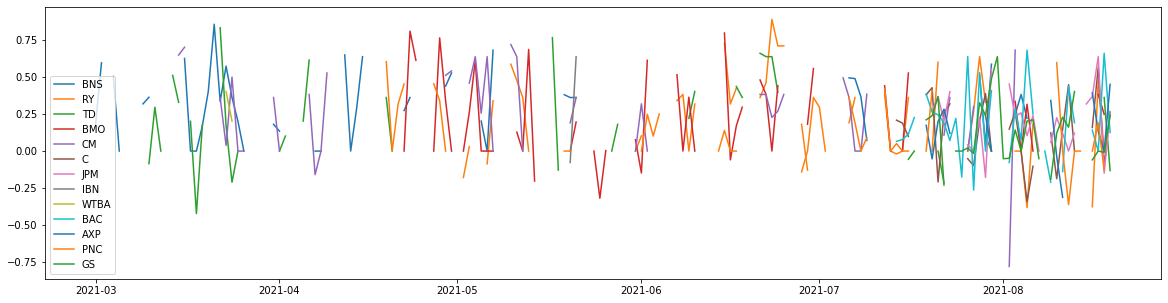

In [242]:
for i in main_f.columns:
    plt.plot(main_f.iloc[796:][i],label=i)
    plt.legend()

## Imputing the sentiments by performing interpolation

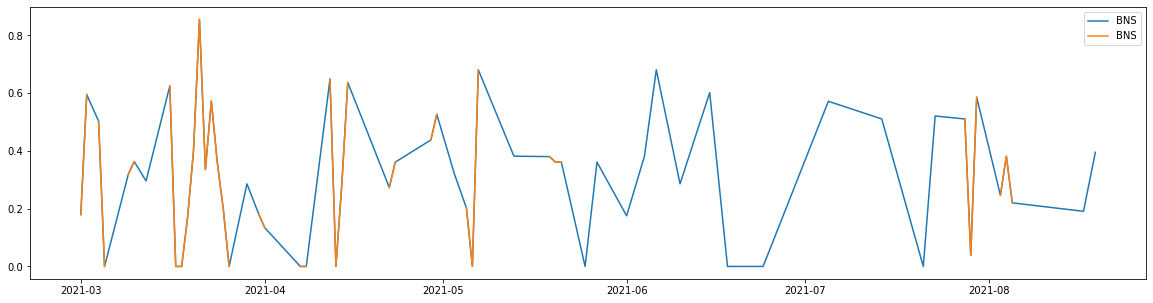

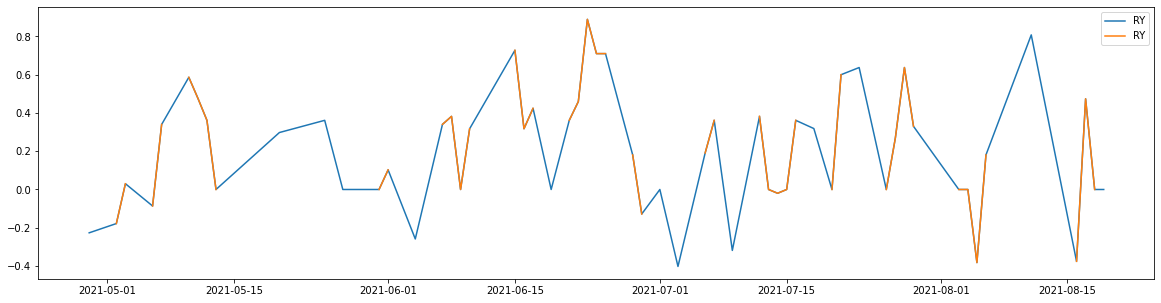

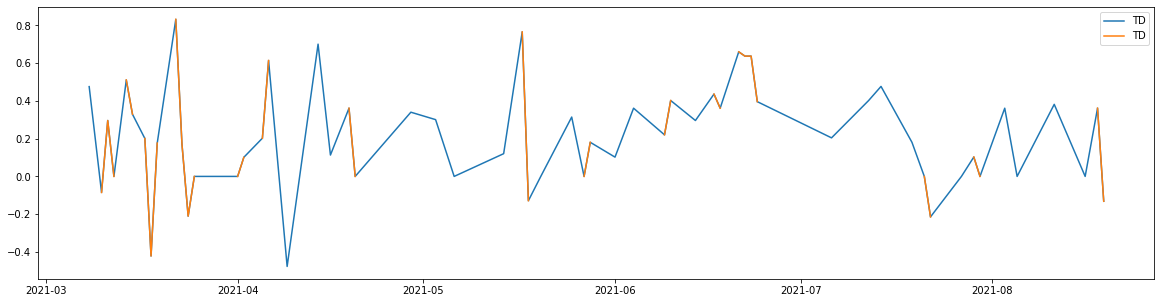

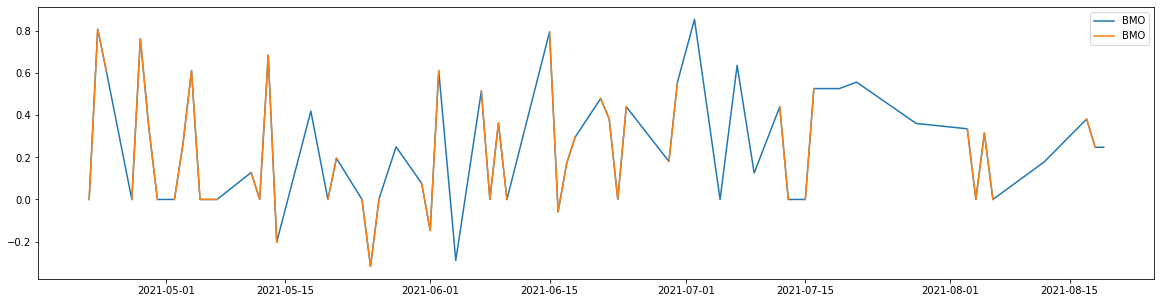

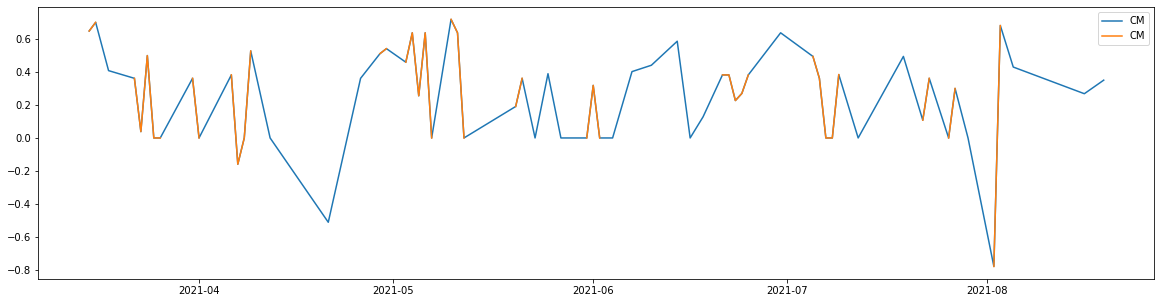

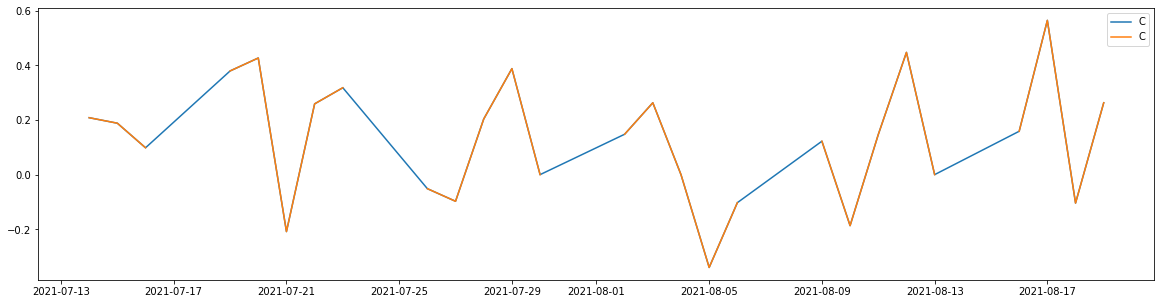

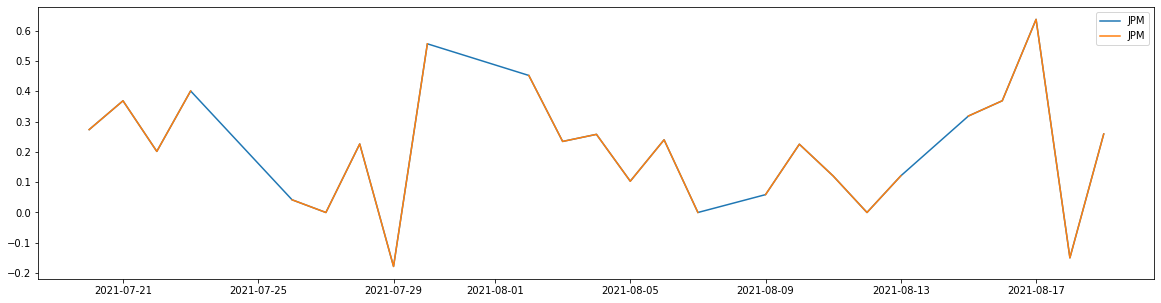

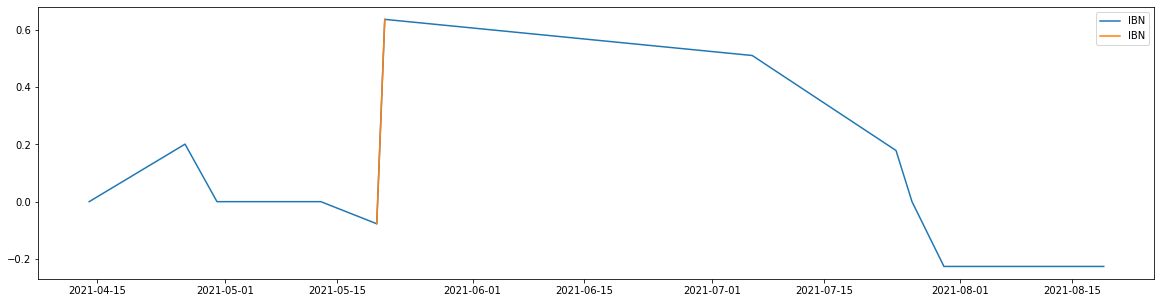

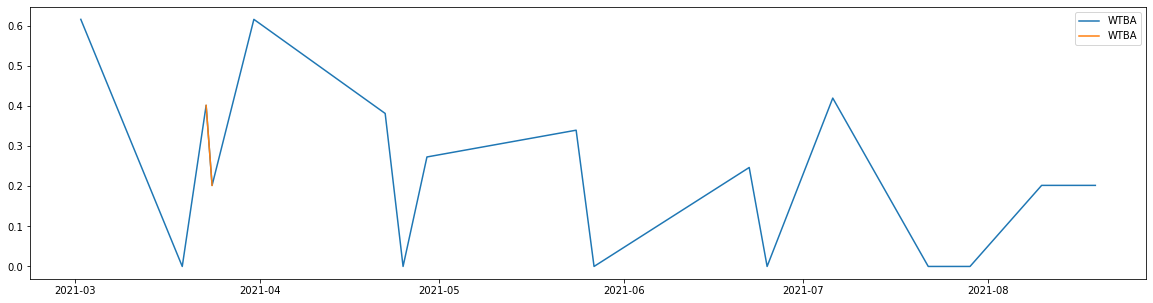

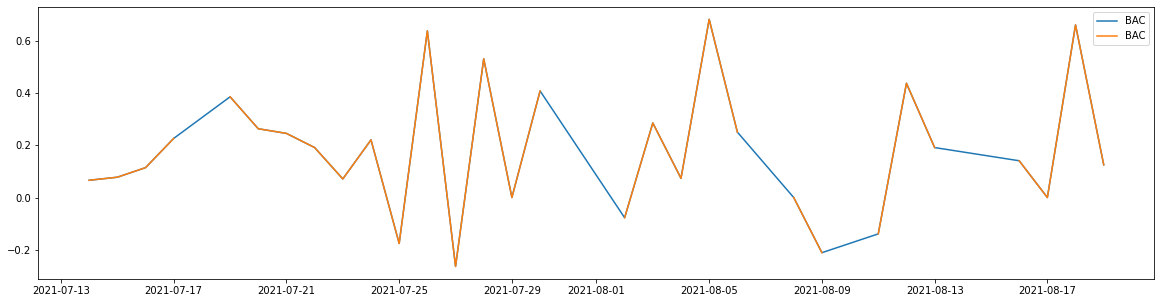

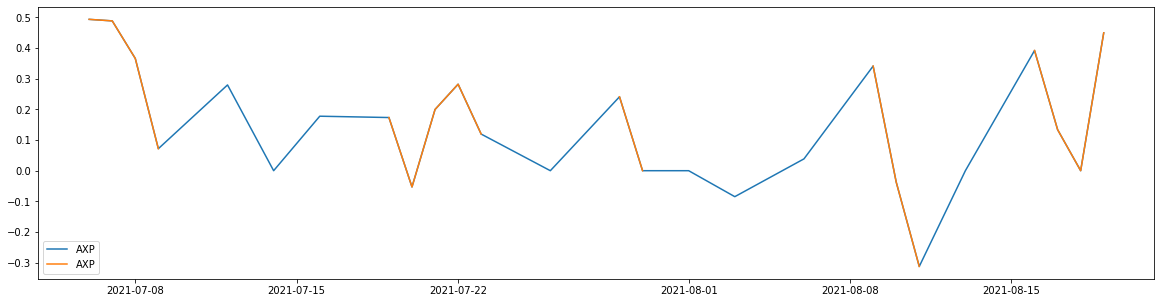

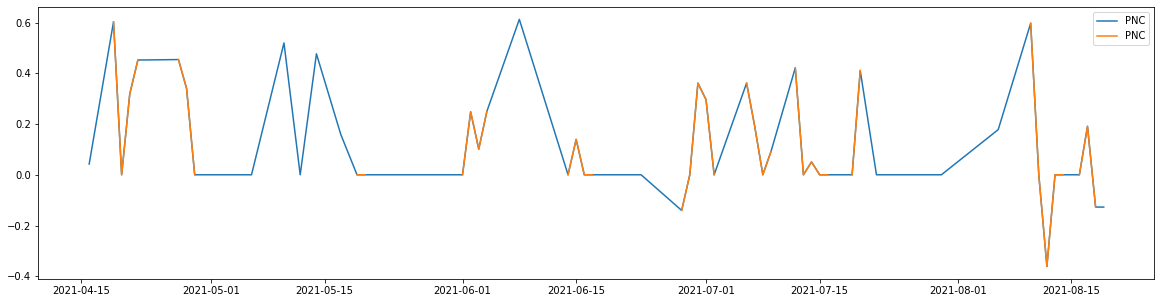

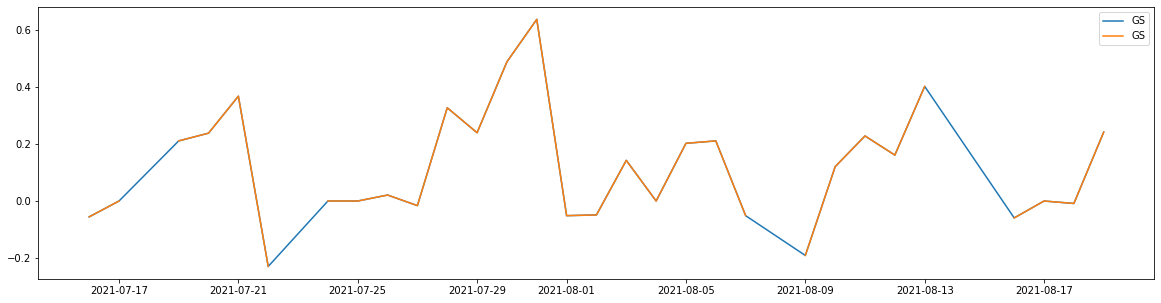

In [243]:
march_f=main_f[796:]
for i in march_f.columns:
    plt.plot(march_f[i].interpolate(),label=i)
    plt.plot(march_f[i],label=i)
    plt.legend()
    plt.show()


In [244]:
march_f=main_f[796:]
for i in march_f.columns:
    march_f[i]=march_f[i].interpolate()
    march_f[i]=march_f[i].bfill()
march_f.head() 


/Users/mohita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mohita/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,BNS,RY,TD,BMO,CM,C,JPM,IBN,WTBA,BAC,AXP,PNC,GS
2021-03-01,0.179700,-0.2263,0.4754,0.0,0.64775,0.208618,0.27334,0.0,0.616600,0.06595,0.4939,0.042286,-0.0556
2021-03-02,0.595050,-0.2263,0.4754,0.0,0.64775,0.208618,0.27334,0.0,0.616600,0.06595,0.4939,0.042286,-0.0556
2021-03-03,0.548925,-0.2263,0.4754,0.0,0.64775,0.208618,0.27334,0.0,0.580329,0.06595,0.4939,0.042286,-0.0556
2021-03-04,0.502800,-0.2263,0.4754,0.0,0.64775,0.208618,0.27334,0.0,0.544059,0.06595,0.4939,0.042286,-0.0556
2021-03-05,0.000000,-0.2263,0.4754,0.0,0.64775,0.208618,0.27334,0.0,0.507788,0.06595,0.4939,0.042286,-0.0556


## Performing the training and testing on the past one month data. The news sentiments and historical closing price from the past 25 days is given as input to the model and the corresponding label is the 5 days ahead closing price.

## Overfitting is avoided by using a validation split and early stopping callback

For, BNS


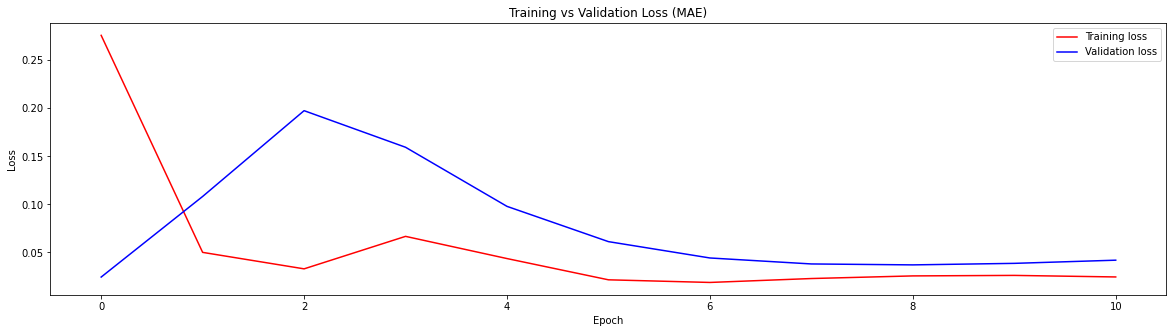

RMSE: Close    1.529235
dtype: float64
MAE: 1.2340553283691407
MAPE: Close    1.95486
dtype: float64 %
For, RY


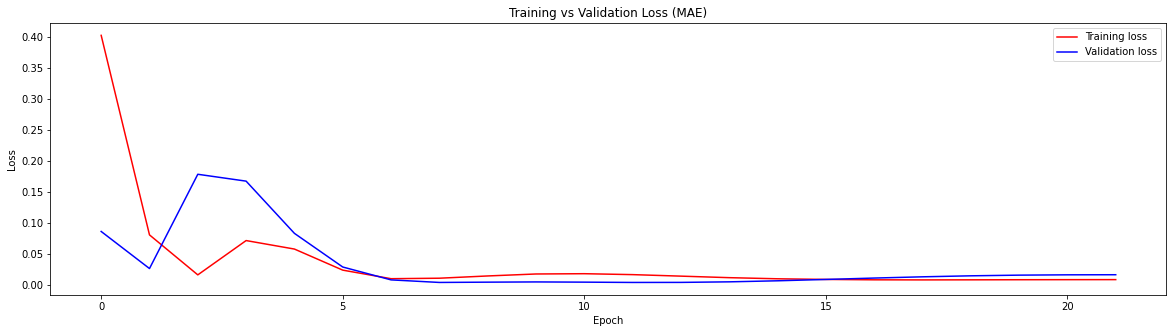

RMSE: Close    2.39329
dtype: float64
MAE: 1.9907508850097657
MAPE: Close    1.945835
dtype: float64 %
For, TD


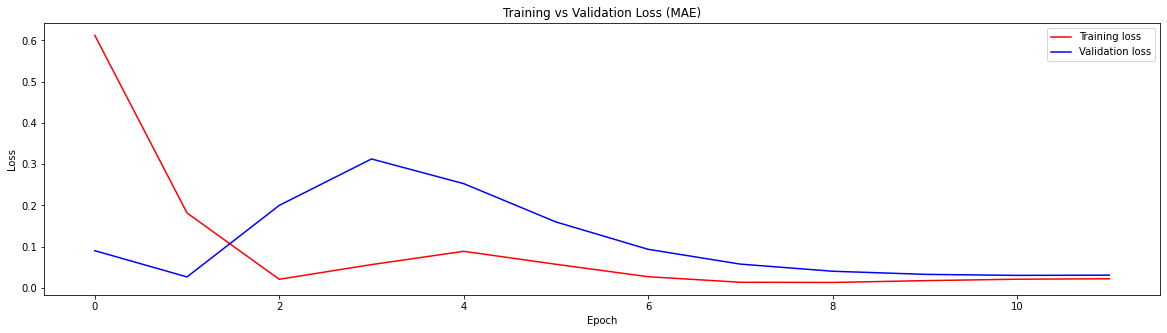

RMSE: Close    1.388967
dtype: float64
MAE: 1.1541336059570313
MAPE: Close    1.716269
dtype: float64 %
For, BMO


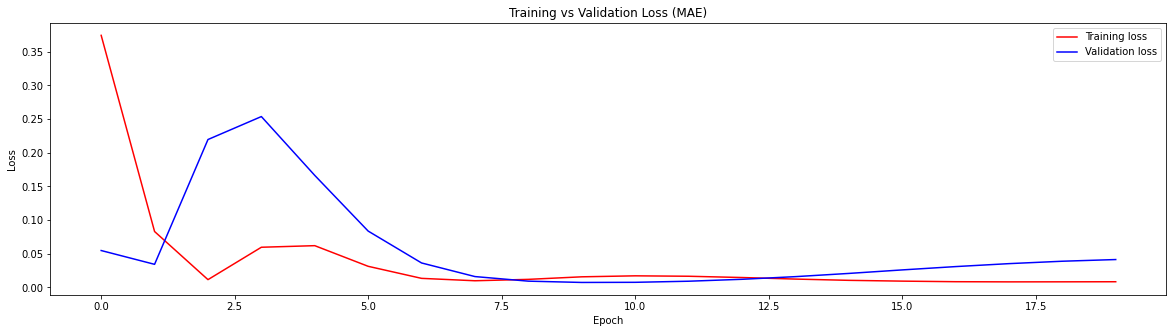

RMSE: Close    1.987093
dtype: float64
MAE: 1.6029182434082032
MAPE: Close    1.593851
dtype: float64 %
For, CM


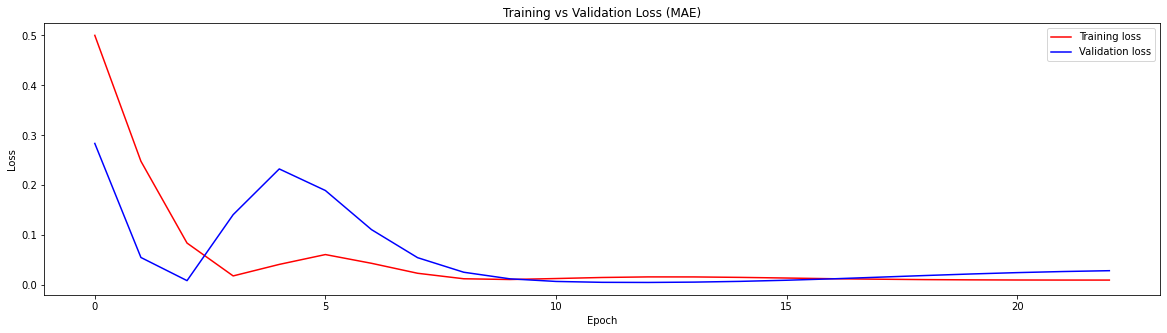

RMSE: Close    2.851835
dtype: float64
MAE: 2.5943325042724608
MAPE: Close    2.228083
dtype: float64 %
For, C


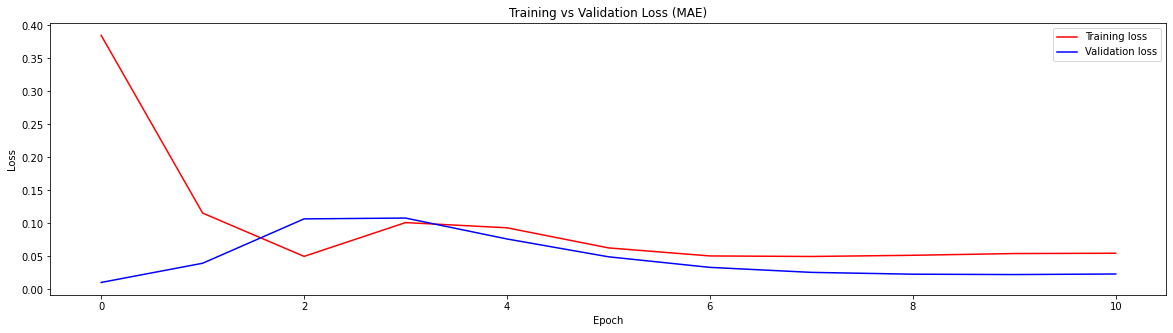

RMSE: Close    3.680012
dtype: float64
MAE: 2.945078659057617
MAPE: Close    4.200878
dtype: float64 %
For, JPM


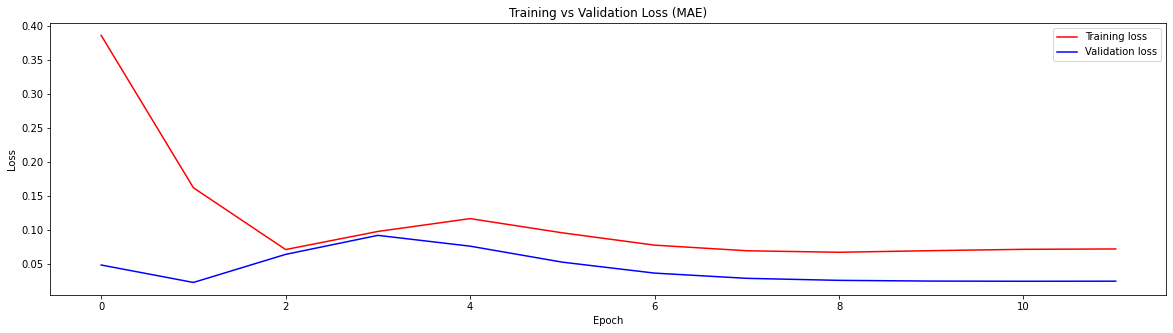

RMSE: Close    4.102695
dtype: float64
MAE: 3.3097213745117187
MAPE: Close    2.135438
dtype: float64 %
For, IBN


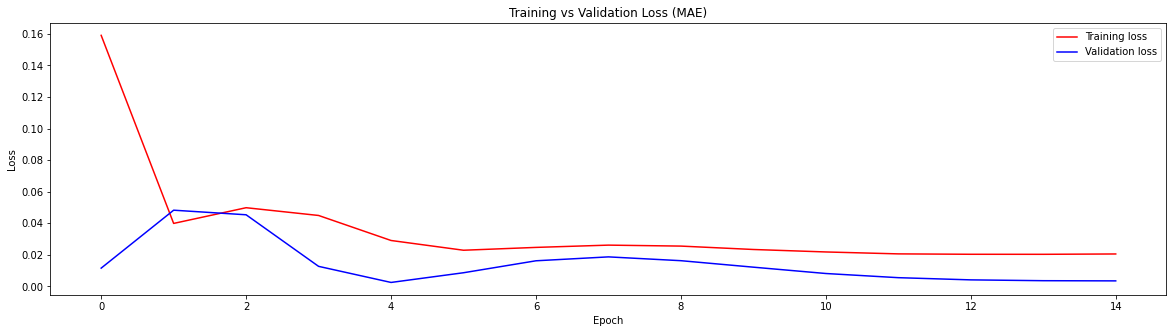

RMSE: Close    1.006898
dtype: float64
MAE: 0.9457051277160644
MAPE: Close    5.024772
dtype: float64 %
For, WTBA


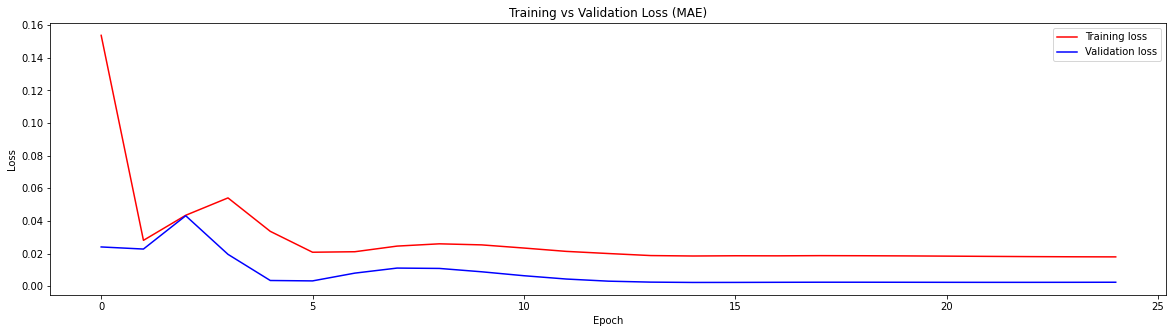

RMSE: Close    1.540318
dtype: float64
MAE: 1.4184066772460937
MAPE: Close    4.717863
dtype: float64 %
For, BAC


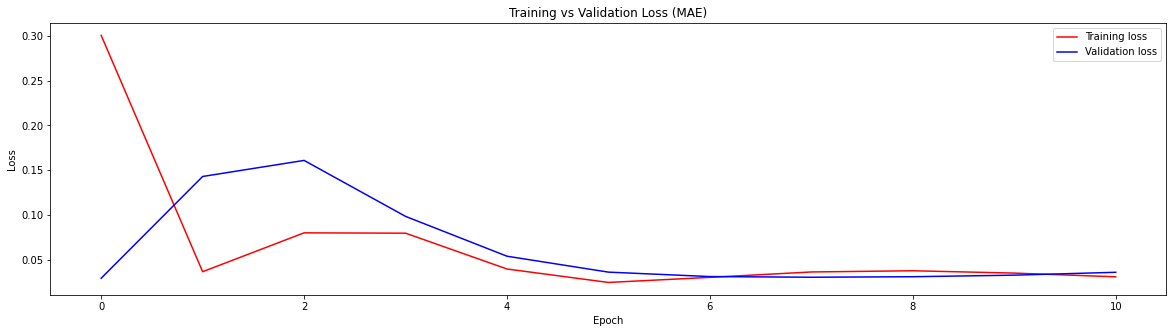

RMSE: Close    2.035801
dtype: float64
MAE: 1.549401092529297
MAPE: Close    3.907899
dtype: float64 %
For, AXP


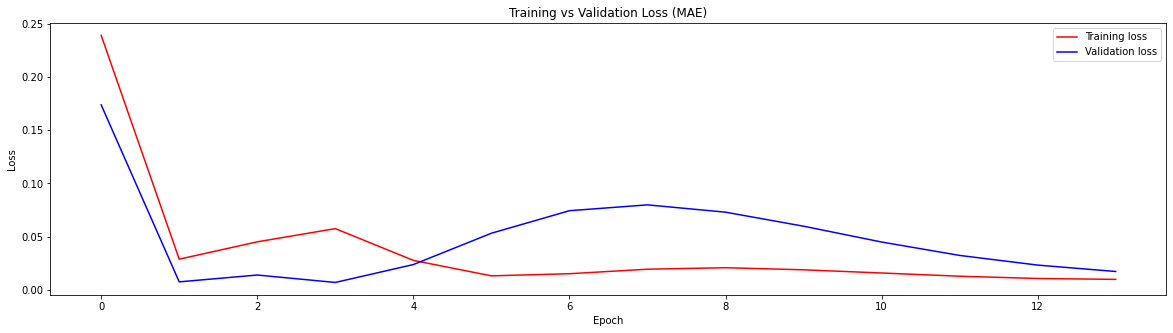

RMSE: Close    6.598487
dtype: float64
MAE: 6.1700294494628904
MAPE: Close    3.657247
dtype: float64 %
For, PNC


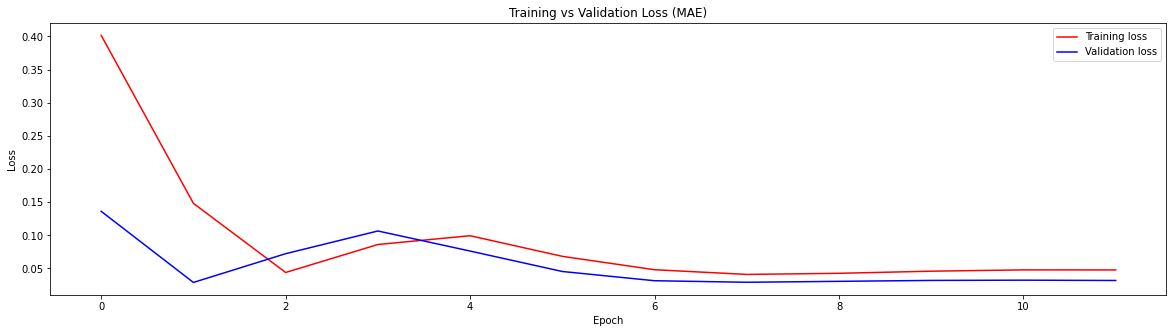

RMSE: Close    5.225324
dtype: float64
MAE: 4.03931884765625
MAPE: Close    2.16089
dtype: float64 %
For, GS


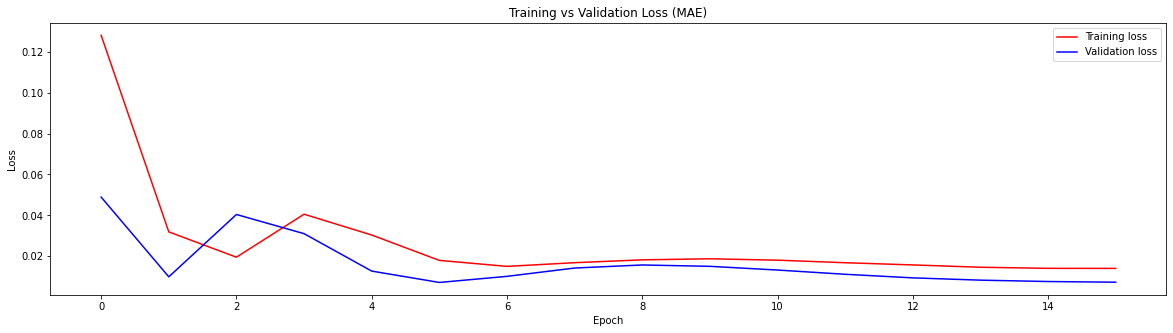

RMSE: Close    19.893258
dtype: float64
MAE: 15.35560302734375
MAPE: Close    3.931311
dtype: float64 %


In [261]:
lag = 25
steps_ahead = 5
n_features = 6
test_len=20

def get_data(ticker):
    df = DataReader(ticker, data_source='yahoo', start='2021-03-01', end=datetime.now())
    return df
def series_to_supervised_dl(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def preprocess_dl(lag,steps_ahead,dff):
    senti=dff.iloc[:,-1:]
    df=dff.iloc[:,:1]
    scaler = MinMaxScaler(feature_range=(0,1))
    df = scaler.fit_transform(df)
    y=df[lag+steps_ahead-1:]
    y_train=y[:-test_len]
    y_test=y[-test_len:]
    #print(len(df))
    #print(len(senti))
    df=pd.DataFrame(df)
    df.index=senti.index
    df["Senti"]=senti
    x=series_to_supervised_dl(df,lag-1)
    x_train=x[:len(y_train)].values
    x_test=x[-test_len-steps_ahead:-steps_ahead].values
    x_train = x_train.reshape((x_train.shape[0], int(x_train.shape[1]/2), 2))
    x_test = x_test.reshape((x_test.shape[0], int(x_test.shape[1]/2), 2))
    return x_train,x_test,y_train,y_test,scaler

def model(lag):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    np.random.RandomState(42)
    random.seed(42)
    
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape= (lag, 2)))
    #model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

def train_univariate(model,x_train,y_train,path):
    reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    checkpoint1 = keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='min')
    es=keras.callbacks.EarlyStopping(patience=10)


    model.compile(optimizer='adam', loss='mean_squared_error')
    history=model.fit(x_train,y_train,epochs=50,validation_split=0.25,verbose=0,batch_size=32,callbacks=[reduce_lr,checkpoint1,es])
    plt.figure()
    plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],color='r', label='Training loss')

    plt.plot(np.arange(len(history.history['loss'])),history.history['val_loss'],color='b', label='Validation loss')
    plt.title('Training vs Validation Loss (MAE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    
def predict_dl(model,path,x_test,y_test,scaler):
    model.load_weights(path)
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions
 
def test(pred,true):
    rmse = np.sqrt(np.mean(((pred - true) ** 2)))
    mae = mean_absolute_error(pred, true)
    mape= np.mean(mae/true) *100
    print("RMSE:",rmse)
    print("MAE:",mae)
    print("MAPE:",mape,"%")
    return rmse, mae, mape
MAPE_err=[]
for i in list_tick:
    print("For,", i)
    df=get_data(i)
    df = df.filter(['Close'])
    true=df[-test_len:]
    #print(len(df))
    dff=pd.concat([df,march_f[i]],axis=1).dropna()
    x_train,x_test,y_train,y_test,scaler=preprocess_dl(lag,steps_ahead,dff)
    #print(x_train.shape)
    #print(y_train.shape)
    path=i+"weights.hdf5"
    model1=model(lag)
    train_univariate(model1,x_train,y_train,path)
    predictions=predict_dl(model1,path,x_test,y_test,scaler)
    rmse, mae, mape=test(predictions,true)
    MAPE_err.append(mape)

## The values stated below are the mean absolute percentage errors for each bank when tested on one month data

In [264]:
pd.DataFrame(MAPE_err,index=tickers).T

,BNS,RY,TD,BMO,CM,C,JPM,IBN,WTBA,BAC,AXP,PNC,GS
Close,1.95486,1.945835,1.716269,1.593851,2.228083,4.200878,2.135438,5.024772,4.717863,3.907899,3.657247,2.16089,3.931311


# The average mean absolute percentage error obtained using this model is around 3%

In [265]:
np.asarray(MAPE_err).mean()

3.0134764715326536

In [287]:
result.T.mean()

BNS     1.768823
RY      1.666748
TD      1.595604
BMO     1.752680
CM      1.875987
C       3.441607
JPM     2.261430
IBN     3.106826
WTBA    3.511812
BAC     3.337760
AXP     3.109555
PNC     2.787654
dtype: float64

In [288]:
result


,stat1,stat2,DL1,DL2
BNS,1.475972,1.447750,2.196709,1.954860
RY,1.264431,1.158005,2.298721,1.945835
TD,1.168521,1.090842,2.406785,1.716269
BMO,1.259598,1.350442,2.806831,1.593851
CM,1.148736,1.282904,2.844227,2.228083
C,2.671106,2.834715,4.059731,4.200878
JPM,1.895053,2.227976,2.787255,2.135438
IBN,2.054463,2.244519,3.103551,5.024772
WTBA,2.846624,2.861901,3.620858,4.717863
BAC,2.617496,2.821382,4.004264,3.907899
